In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

%matplotlib inline

In [2]:
path = 'C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/'

In [7]:
start = datetime.now()
if not os.path.isfile('C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/data.csv', mode='w')
    
    row = list()
    files=['C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/combined_data_1.txt','C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/combined_data_2.txt', 
           'C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/combined_data_3.txt', 'C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Reading ratings from C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/combined_data_1.txt...
Done.

Reading ratings from C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/combined_data_2.txt...
Done.

Reading ratings from C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/combined_data_3.txt...
Done.

Reading ratings from C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/combined_data_4.txt...
Done.

Time taken : 0:03:36.282498


In [2]:
df = pd.read_csv('C:/Users/silri/Desktop/Applied_AI/Movie_RS_DataSet/data.csv', header=None)

In [3]:
df.head()

,0,1,2,3
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [4]:
df.rename({0:'Movie_ID',1:'User_ID',2:'Rating',3:'Date'},axis=1,inplace=True)

In [5]:
df.head()

,Movie_ID,User_ID,Rating,Date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [6]:
#We will sort the data in ascending order of date

df.sort_values(by=['Date'],axis=0,ascending=True,inplace=True)

In [19]:
df.head()

,Movie_ID,User_ID,Rating,Date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [20]:
#Check the null values inside the dataset

df.isnull().sum()

Movie_ID    0
User_ID     0
Rating      0
Date        0
dtype: int64

In [22]:
#Check for duplicated records
df.duplicated(['Movie_ID','User_ID','Rating']).sum()

0

Good News! : 

    1. We didn't get any null values
    
    2. We didn't get any duplicated values    

In [ ]:
#EDA - 

#1. Distribution of ratings
#2. Add a new column day of week
#3. No. of movies rated by a user
#4. Plot pdf and cdf of #of movies rated by a user
#5. Check the quantile values
#6. Zoom the 75th to 100th percentile values.
#7. How many ratings are there in the 5% unusual behaviour
#8. #users rated a given movie
#9. #of ratings given during the weekend
#10. Avg rating in a day of week


In [7]:
#Basic Statistics

df.head()

,Movie_ID,User_ID,Rating,Date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [8]:
df['Rating'].value_counts()

4    33750958
3    28811247
5    23168232
2    10132080
1     4617990
Name: Rating, dtype: int64

In [19]:
print(f"Total # of Ratings : {df['Rating'].count()}")
print(f"Total # of Users : {len(df['User_ID'].unique())}")
print(f"Total # of Movies : {len(df['Movie_ID'].unique())}")

Total # of Ratings : 100480507
Total # of Users : 480189
Total # of Movies : 17770


In [14]:
len(df['User_ID'].unique())

480189

In [20]:
print(f"In average 1 User rates : {df['Rating'].count()/len(df['User_ID'].unique())} movies")

In average 1 User rates : 209.25199660966828 movies


In [ ]:
## We can see that the #of users are more than the #of movies
## We have many to many relationship, like one user rates many movies
## In average 1 users rates 209 movies --> Quite an interesting number 
        #--> We need to assess this #
    #--> May be its due to outliers
    #--> Need to plot a distribution

In [21]:
#Before we proceed , we need to split the data into train dataset and test dataset
# Why we are doing this step now, because in real world the test data point will not be preprocessed

In [24]:
df.shape,df.shape[0]

((100480507, 4), 100480507)

In [34]:
df_train = df.iloc[:int(df.shape[0]*0.8)]

In [35]:
df_test = df.iloc[int(df.shape[0]*(0.8)):]

In [36]:
df_test.head()

,Movie_ID,User_ID,Rating,Date
32637772,5926,2294429,2,2005-08-08
55518921,10158,1743373,4,2005-08-08
96207802,17064,381625,5,2005-08-08
7239677,1443,1252933,5,2005-08-08
6107277,1201,1434500,4,2005-08-08


In [45]:
#Run the basic statistics on the Train data
print("Train Stats")
print("-"*50)
print(f"Total # of ratings in the Train Data : {df_train['Rating'].count()}")
print(f"Total # of users in the Train Data : {len(df_train['User_ID'].unique())}")
print(f"Total # of movies in the Train Data : {len(df_train['Movie_ID'].unique())}")

Test Stats
--------------------------------------------------
Total # of ratings in the Train Data : 80384405
Total # of users in the Train Data : 405041
Total # of movies in the Train Data : 17424


In [41]:
#In train dataset we have less users, than the entire dataset
#In train dataset we have less movies, than the enitre dataset

#While training the model, it is very obvious to have less #of records, because, in real world we might get new data points,
#That means, a new user or a new movie might be introduced.

In [42]:
#Check #of movie rating /user
print(f"In Average 1 user rates : {df_train['Rating'].count()/len(df_train['User_ID'].unique())}")

In Average 1 user rates : 198.4599213412963


In [44]:
#Run the basic statistics on the test data
print("Test Stats")
print("-"*50)
print(f"Total # of ratings in the Train Data : {df_test['Rating'].count()}")
print(f"Total # of users in the Train Data : {len(df_test['User_ID'].unique())}")
print(f"Total # of movies in the Train Data : {len(df_test['Movie_ID'].unique())}")

Test Stats
--------------------------------------------------
Total # of ratings in the Train Data : 20096102
Total # of users in the Train Data : 349312
Total # of movies in the Train Data : 17757


<AxesSubplot:xlabel='Rating'>

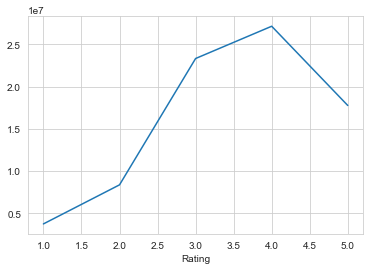

In [49]:
#Check the distribution of rating vs No of users

df_train.groupby(by='Rating')['User_ID'].count().plot()

C:\Users\silri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '# of users')

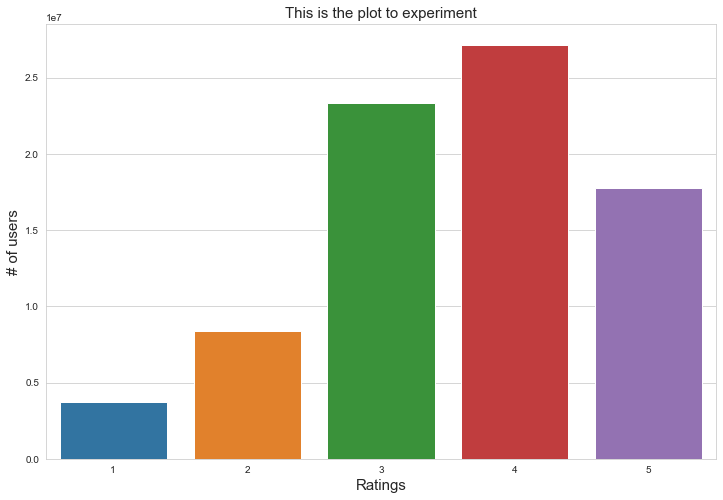

In [75]:
#How to increase the figsize of subplots
# Ref : https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
# Ref :  

fig, ax = plt.subplots(figsize=(12,8))
plt.title("This is the plot to experiment",fontsize=15)
sns.countplot(df_train['Rating'],)
plt.xlabel("Ratings",fontsize=15)
plt.ylabel("# of users",fontsize=15)

In [ ]:
# Here we can see that, 